In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.7 MB/s eta 0:00:00


In [2]:
import sys, os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import optuna
import re
from optuna.visualization import plot_slice
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.svm import SVC, LinearSVC


import xgboost as xgb
import lightgbm as lgb
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from google.colab import drive
drive.mount('/content/drive')

sys.path.insert(0,'/content/drive/MyDrive/Libraries')
IS_MASTER = True # Set this to True in MASTER Notebook so that it does not use the default parameters in processing notebook.
ROOT_FOLDER = '/content/drive/MyDrive/Sports/NCAABB2024/'
DATA_FOLDER = f'{ROOT_FOLDER}data/'
OUTPUT_FOLDER = f'{ROOT_FOLDER}output/'
NOTEBOOK_FOLDER = f'{ROOT_FOLDER}notebooks/'
DATA_REV = '2'
SYMBOL = '2024'

# PKL FILES where we save the output
X_NOSEED_OUTPUT = f'{DATA_FOLDER}X_NOSEED_OUTPUT_{DATA_REV}.pkl'
X_SEED_OUTPUT = f'{DATA_FOLDER}X_SEED_OUTPUT_{DATA_REV}.pkl'
LABEL_OUTPUT = f'{DATA_FOLDER}LABEL_OUTPUT_{DATA_REV}.pkl'
ALL_STATISTICS_OUTPUT = f'{DATA_FOLDER}ALLSTATS_{DATA_REV}.pkl'
MODEL_OUTPUT = f'{DATA_FOLDER}MODEL_{DATA_REV}.pkl'
MteamDict_OUTPUT = f'{DATA_FOLDER}MTEAM_DICT.pkl'
WteamDict_OUTPUT = f'{DATA_FOLDER}WTEAM_DICT.pkl'

#
# Create output folder
#
if not os.path.exists(f'{DATA_FOLDER}'):
        os.makedirs(f'{DATA_FOLDER}')

if not os.path.exists(f'{OUTPUT_FOLDER}'):
        os.makedirs(f'{OUTPUT_FOLDER}')

features_seed = ['EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'BArcPctDiff',
            'TORateDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'AssistTODiff', 'EffSmallDiff',
            'SeedDiff']

features_noseed = ['EloDiff', 'AvgScoringMarginDiff', 'PythagoreanDiff', 'PtsPerPossDiff', 'WinPctDiff', \
            'EffectiveFGPctDiff', 'StealBlockFoulDiff', 'FTRateDiff', 'BArcPctDiff',
            'TORateDiff', 'DR_advDiff', 'EFG_noDiff', 'OR_advDiff', 'AssistTODiff', 'EffSmallDiff']

!unzip $ROOT_FOLDER/march-machine-learning-mania-2024*.zip -d $DATA_FOLDER

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Sports/NCAABB2024//march-machine-learning-mania-2024.zip
replace /content/drive/MyDrive/Sports/NCAABB2024/data/2024_tourney_seeds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
#
# Import Libraries
#
import print_and_log

# Let's save the original print method in ori_print
#---------------------------------------------------
ori_print = print
# Now we set the priunt method to be modified print
#--------------------------------------------------
print = print_and_log.run('preproc', './preprocess.log', 'DEBUG')

# Perform EDA and Build Datasets

Archive:  /content/drive/MyDrive/Sports/NCAABB2024//march-machine-learning-mania-2024.zip
replace /content/drive/MyDrive/Sports/NCAABB2024/data/2024_tourney_seeds.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


2024-03-20 05:01:19,834 - preproc - INFO - X_NOSEED_OUTPUT_1.pkl
INFO:preproc:X_NOSEED_OUTPUT_1.pkl
2024-03-20 05:01:19,845 - preproc - INFO - X_NOSEED_OUTPUT_1.pkl not loaded
INFO:preproc:X_NOSEED_OUTPUT_1.pkl not loaded
2024-03-20 05:01:19,849 - preproc - INFO - X_SEED_OUTPUT_1.pkl
INFO:preproc:X_SEED_OUTPUT_1.pkl
2024-03-20 05:01:19,859 - preproc - INFO - X_SEED_OUTPUT_1.pkl not loaded
INFO:preproc:X_SEED_OUTPUT_1.pkl not loaded
2024-03-20 05:01:19,862 - preproc - INFO - LABEL_OUTPUT_1.pkl
INFO:preproc:LABEL_OUTPUT_1.pkl
2024-03-20 05:01:19,871 - preproc - INFO - LABEL_OUTPUT_1.pkl not loaded
INFO:preproc:LABEL_OUTPUT_1.pkl not loaded
2024-03-20 05:01:19,875 - preproc - INFO - ALLSTATS_1.pkl
INFO:preproc:ALLSTATS_1.pkl
2024-03-20 05:01:19,883 - preproc - INFO - ALLSTATS_1.pkl not loaded
INFO:preproc:ALLSTATS_1.pkl not loaded
2024-03-20 05:01:19,887 - preproc - INFO - MODEL_1.pkl
INFO:preproc:MODEL_1.pkl
2024-03-20 05:01:19,895 - preproc - INFO - MODEL_1.pkl not loaded
INFO:preproc:M

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Season  4234 non-null   int64
 1   Seed    4234 non-null   int64
 2   TeamID  4234 non-null   int64
dtypes: int64(3)
memory usage: 99.4 KB


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Gender
0,2003,134,1421,92,1411,84,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22,1
1,2003,136,1112,80,1436,51,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15,1
2,2003,136,1113,84,1272,71,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18,1
3,2003,136,1141,79,1166,73,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21,1
4,2003,136,1143,76,1301,74,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12857 entries, 0 to 12856
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Season     12857 non-null  object 
 1   TeamID     12857 non-null  object 
 2   Gender     12857 non-null  object 
 3   NumWins    12857 non-null  float64
 4   NumLosses  12857 non-null  float64
 5   WinPct     12857 non-null  float64
dtypes: float64(3), object(3)
memory usage: 703.1+ KB


<ipython-input-5-3e15d0ce6168>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  win_score_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
<ipython-input-5-3e15d0ce6168>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lose_score_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()


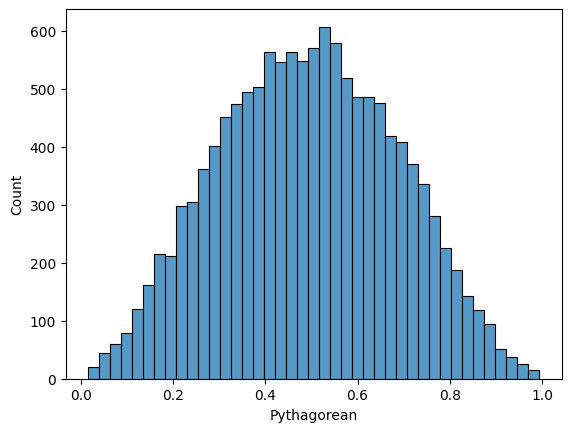

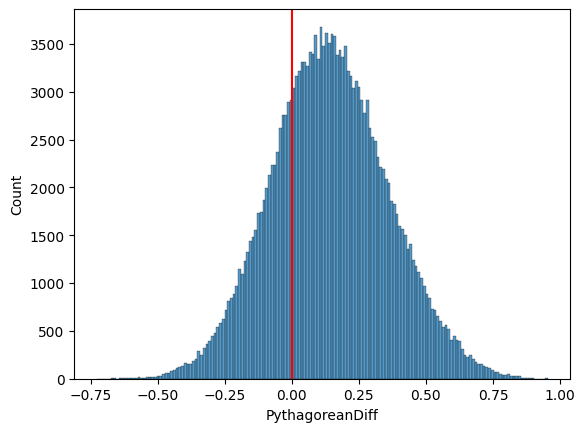

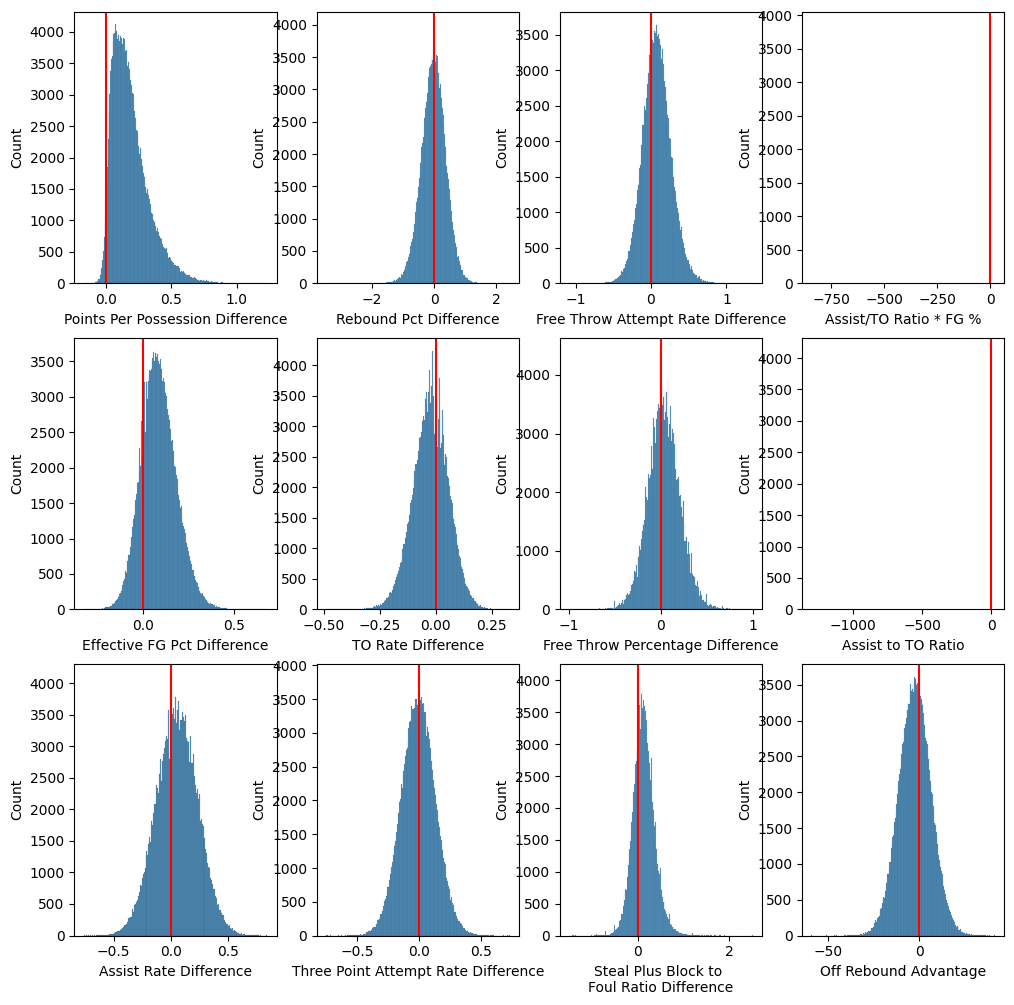

<ipython-input-5-cf7793d4a390>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_columns.loc[:, 'Season'] = sabermetrics['Season']
<ipython-input-5-cf7793d4a390>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losing_columns.loc[:, 'Season'] = sabermetrics['Season']


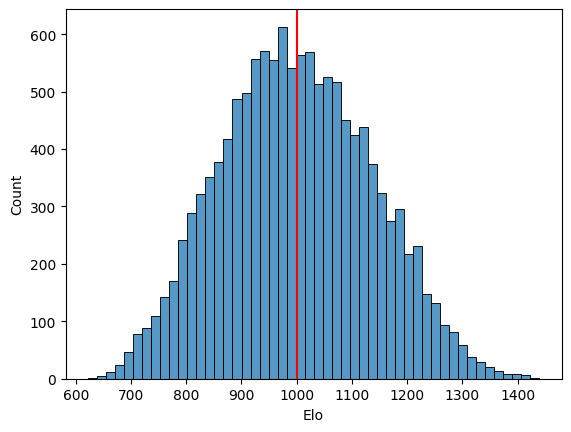

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2142 entries, ('2003', '1421', '1411', 1) to ('2023', '3261', '3234', 0)
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PtsPerPossDiff        2142 non-null   float64
 1   EffectiveFGPctDiff    2142 non-null   float64
 2   AvgScoringMarginDiff  2142 non-null   float64
 3   AssistRateDiff        2142 non-null   float64
 4   AssistTODiff          2142 non-null   float64
 5   ReboundPctDiff        2142 non-null   float64
 6   StealBlockFoulDiff    2142 non-null   float64
 7   TORateDiff            2142 non-null   float64
 8   BArcPctDiff           2142 non-null   float64
 9   FTRateDiff            2142 non-null   float64
 10  FTPctDiff             2142 non-null   float64
 11  WinPctDiff            2142 non-null   float64
 12  EloDiff               2142 non-null   float64
 13  DR_advDiff            2142 non-null   float64
 14  EFG_noDiff            2

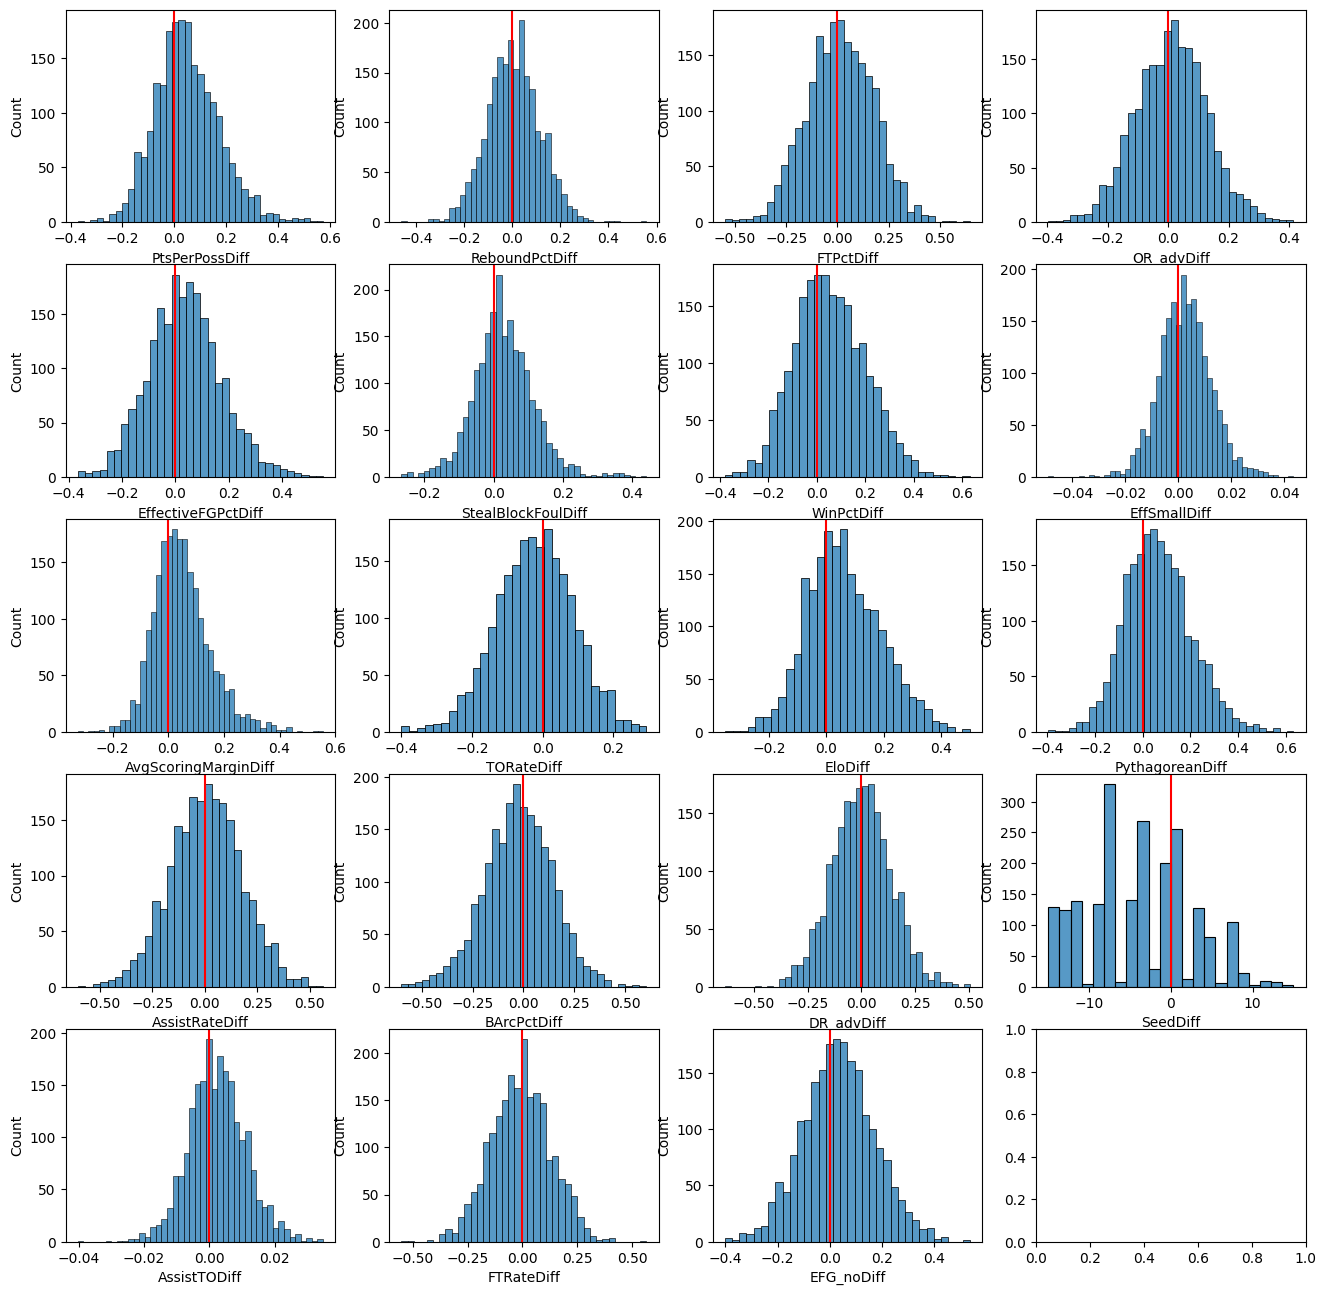

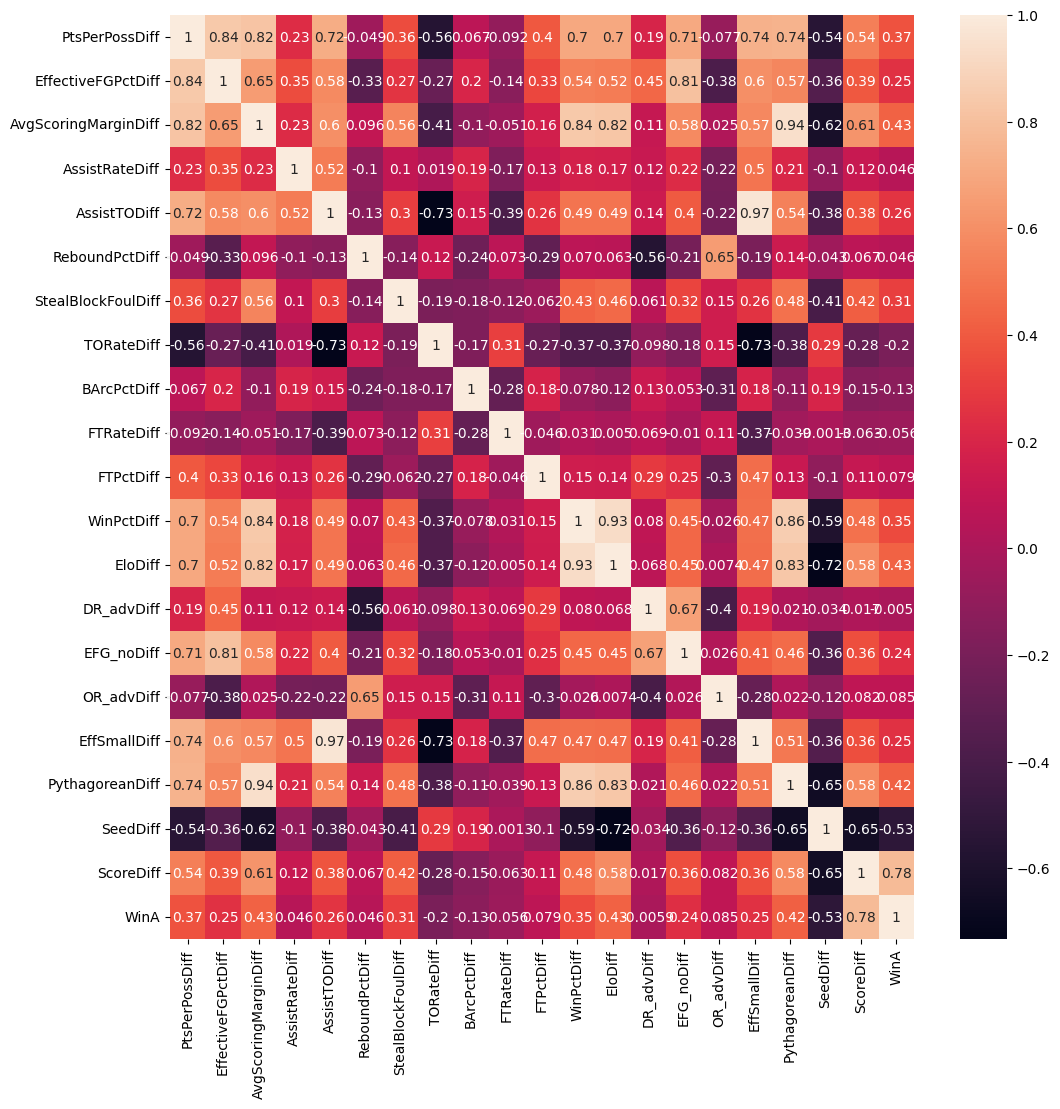

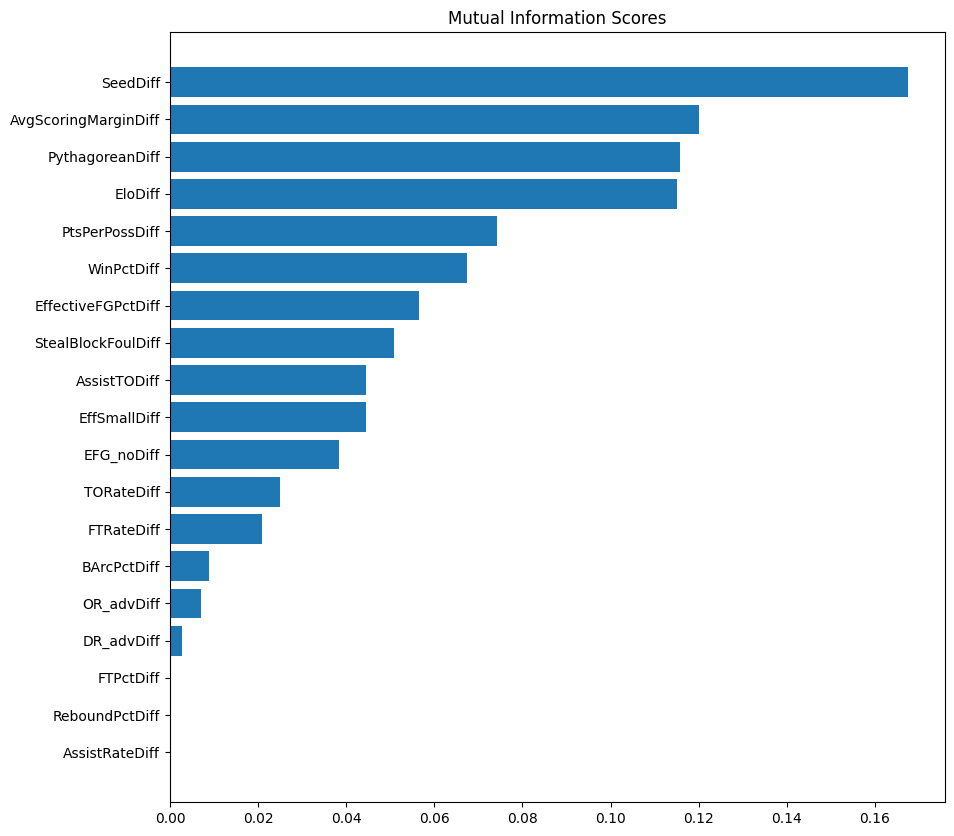

CPU times: user 4min 44s, sys: 14 s, total: 4min 58s
Wall time: 6min 42s


In [5]:
%%time
os.chdir(NOTEBOOK_FOLDER)
# Now, we run the Preprocessing Notebook using the %run magic
#-------------------------------------------------------------
%run {SYMBOL}_Unzip_EDA.ipynb
# Finally, after running notebook, we set the print method back to the original print method.
#-----------------------------------------------------

# Train the Model and Run Quick Verification on 2023

In [6]:
%%time
os.chdir(NOTEBOOK_FOLDER)
# Now, we run the Preprocessing Notebook using the %run magic
#-------------------------------------------------------------
%run {SYMBOL}_Train_Eval_Model.ipynb
# Finally, after running notebook, we set the print method back to the original print method.
#-----------------------------------------------------

2024-03-20 05:07:36,653 - preproc - INFO - 18 4542
INFO:preproc:18 4542


[LightGBM] [Info] Number of positive: 2271, number of negative: 2271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 4542, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1816, number of negative: 1817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 3633, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1817, number of negative: 1816
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 3633, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000

2024-03-20 05:17:00,694 - preproc - INFO - 	 -> Loss (rms) 0.2060
INFO:preproc:	 -> Loss (rms) 0.2060
2024-03-20 05:17:00,892 - preproc - INFO - Model Score: 0.6642
INFO:preproc:Model Score: 0.6642


[LightGBM] [Info] Number of positive: 2405, number of negative: 2405
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 4810, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1924, number of negative: 1924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 3848, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1924, number of negative: 1924
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 3848, number of 

,PtsPerPossDiff,EffectiveFGPctDiff,AvgScoringMarginDiff,AssistRateDiff,AssistTODiff,ReboundPctDiff,StealBlockFoulDiff,TORateDiff,BArcPctDiff,FTRateDiff,FTPctDiff,WinPctDiff,EloDiff,DR_advDiff,EFG_noDiff,OR_advDiff,EffSmallDiff,PythagoreanDiff
0,0.174450,0.201843,0.009661,-0.116058,0.006613,-0.064014,-0.105006,-0.102359,0.194726,-0.052930,0.384789,0.030303,0.002013,0.219660,0.193432,-0.121609,0.014058,-0.000881
1,0.108018,0.046836,0.077437,0.094775,0.003104,0.134968,0.029528,0.029803,-0.102170,-0.079888,0.234165,0.140021,0.100252,-0.238487,-0.033204,0.098742,0.007544,0.153693
2,-0.095357,-0.082889,-0.025218,-0.039769,-0.004236,-0.001277,0.047640,0.053638,0.038955,-0.185997,-0.289924,-0.030361,-0.012770,-0.097464,-0.014664,0.169572,-0.009412,-0.052944
3,0.228326,0.173790,0.070152,0.154613,0.011110,0.104861,-0.009379,-0.131237,0.184300,-0.148275,0.243277,0.156250,0.041777,-0.137456,0.097568,0.055080,0.014590,0.149026
4,0.020239,0.042305,0.110671,-0.029009,-0.000910,-0.104327,0.040149,0.036866,0.257032,0.052666,-0.210067,0.197769,0.249360,0.142680,0.084749,-0.043932,-0.005178,0.177066


<ipython-input-6-7879885f8d91>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_m['teamNameA'] = df_test_m['teamA'].astype(int).map(mTeamDict)
<ipython-input-6-7879885f8d91>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_m['teamNameB'] = df_test_m['teamB'].astype(int).map(mTeamDict)
<ipython-input-6-7879885f8d91>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

CPU times: user 19min 26s, sys: 1min 7s, total: 20min 33s
Wall time: 19min 37s


In [7]:
%%time
os.chdir(NOTEBOOK_FOLDER)
# Now, we run the Preprocessing Notebook using the %run magic
#-------------------------------------------------------------
%run {SYMBOL}_Submit.ipynb
# Finally, after running notebook, we set the print method back to the original print method.
#-----------------------------------------------------

100%|██████████| 50/50 [06:02<00:00,  7.25s/it]

CPU times: user 13min 3s, sys: 7.6 s, total: 13min 11s
Wall time: 12min 22s
